## Importing the Dataset

In [53]:
from torchvision import datasets, transforms
import numpy as np
np.random.seed(44)  

#
transform = transforms.ToTensor()
#
train_dataset = datasets.FashionMNIST (root='data', train=True, transform=transform, download=False)
#
test_dataset = datasets.FashionMNIST (root='data', train=False, transform=transform, download=False)



Checking properties of the datset

In [54]:
print("Training set size:", len(train_dataset))
print("Test set size:", len(test_dataset))
print("Image size:", train_dataset[0][0].shape) 
print("Number of classes:", len(train_dataset.classes))
print("Class labels:", train_dataset.classes)

Training set size: 60000
Test set size: 10000
Image size: torch.Size([1, 28, 28])
Number of classes: 10
Class labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Taking a look at the images

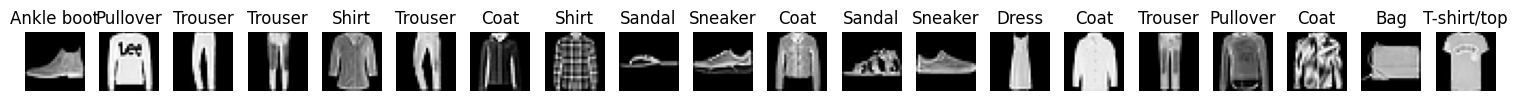

In [55]:
import matplotlib.pyplot as plt

num_samples = 20

samples = [test_dataset[i][0].numpy().squeeze() for i in range(num_samples)]
labels = [test_dataset[i][1] for i in range(num_samples)]

plt.figure(figsize=(15, 1))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(samples[i], cmap="gray")
    plt.title(f"{train_dataset.classes[labels[i]]}") 
    plt.axis("off")

plt.tight_layout()
plt.show()

Processing the dataset

In [56]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



Defining a base class for Neural layers

In [57]:
class NeuralLayer:
    def __init__(self):
        self.training = True
    
    def train(self):
        self.training = True

    def eval(self):
        self.training = False

Implementation of dense layer

In [58]:
def normal_xavier_init (nY, nX):
    std = (2 / (nX+nY))**0.5
    W = np.random.randn(nY, nX) * std
    return W

class DenseLayer (NeuralLayer):
    pass
    def __init__(self, nX, nY, Adam=True, beta1=0.9, beta2=0.999, epsilon=1e-6):
        super().__init__()
        self.W = normal_xavier_init (nY, nX)
        self.B = np.zeros(nY)

        self.Adam = Adam
        if self.Adam:
            self.beta1 = beta1
            self.beta2 = beta2
            self.epsilon = epsilon
            self.t = 0

            self.m_w = np.ones_like(self.W) * 0.4
            self.m_b = np.zeros_like(self.B)

            self.v_w = np.ones_like(self.W) * 0.16
            self.v_b = np.zeros_like(self.B)

    def forward (self, X_in):
        self.X = X_in
        Y = np.matmul (self.X, np.transpose(self.W)) + self.B
        if np.isnan(Y).any(): 
            print("NaN detected in DenseLayer forward pass")
        return Y
    
    def backward (self, G_y, alpha):
        G_x = np.matmul (G_y, self.W)
        G_w = np.matmul (np.transpose(G_y), self.X)
        G_b = np.sum (G_y, axis=0)

        if self.Adam:   
            self.t = self.t + 1
            self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * G_w
            self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * G_b
            self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * G_w**2
            self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * G_b**2

            m_hat_w = self.m_w / (1 - np.transpose(self.beta1))
            m_hat_b = self.m_b / (1 - np.transpose(self.beta1))
            v_hat_w = self.v_w / (1 - np.transpose(self.beta2))
            v_hat_b = self.v_b / (1 - np.transpose(self.beta2))

            self.W = self.W - alpha * G_w
            self.B = self.B - alpha * G_b

        else:
            self.W = self.W - alpha * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            self.B = self.B - alpha * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

        if np.isnan(self.W).any() or np.isnan(self.B).any(): 
            print("NaN detected in DenseLayer weights/biases after update")
        
        return G_x
   


Implementation of ReLU Activation function

In [59]:
class ReLU (NeuralLayer):
    pass
    def __init__(self):
        super().__init__()

    def forward (self, X_in):
        self.X = X_in
        return np.maximum (self.X, 0)
    
    def backward (self, G_y, alpha):
        G_x = G_y * (self.X >= 0)
        return G_x

Implementation of Softmax loss function

In [60]:
class Softmax (NeuralLayer):
    pass
    def __init__(self):
        super().__init__()

    def forward (self, X_in):
        self.X = X_in
        shiftX = np.max(self.X, axis=1, keepdims=True)
        numerators = np.exp(self.X- shiftX)
        denominator = np.sum(numerators, axis=1, keepdims=True)
        self.Y = numerators / denominator 
        return self.Y

    def backward (self, Y, alpha):
        G_x = Y
        return G_x


Implementation of Dropout Layer

In [61]:
class Dropout (NeuralLayer):
    pass
    def __init__ (self, probability=0.35):
        super().__init__()
        self.probability = probability
    def forward (self, X):
        if self.training:
            prob_arr = np.random.rand(X.shape[0], X.shape[1])
            self.mask = (prob_arr >= self.probability)
            X_sel_scaled = X * self.mask / (1 - self.probability)
            return X_sel_scaled
        return X 
    
    def backward (self, G_y, alpha):
        G_x = G_y * self.mask / (1 - self.probability)
        return G_x
        

Implementation of Batch Normalisation

In [62]:
class BatchNorm (NeuralLayer):
    pass
    def __init__ (self, N, epsilon=1e-5):
        super().__init__()
        self.N = N
        self.gamma = np.ones(N)*0.5
        self.beta = np.zeros(N)
        self.epsilon = epsilon

    def forward (self, X_in):
        self.X = X_in
        self.mu = np.mean(self.X, axis=0)
        self.var = np.var(self.X, axis=0)
        self.Xhat = (self.X - self.mu) * (self.var + self.epsilon)**(-0.5)
        self.Y = self.gamma * self.Xhat + self.beta
        return self.Y
    
    def backward (self, G_y, alpha):
        G_gamma = np.sum (G_y * self.Xhat, axis=0)
        G_beta = np.sum (G_y, axis=0)
    
        G_Xhat = G_y * self.gamma
        G_x = (self.N * G_Xhat - np.sum(G_Xhat, axis=0) - self.Xhat * np.sum(G_Xhat * self.Xhat, axis=0)) / (self.N * (self.var + self.epsilon)**0.5)
        
        self.gamma = self.gamma - alpha * G_gamma
        self.beta = self.beta - alpha * G_beta

        return G_x

Sequential layer stacking mechanism

In [63]:
class Sequential (NeuralLayer):
    pass
    def __init__ (self, *layers):
        super().__init__()
        self.layers = layers

    def train (self):
        for l in self.layers:
            l.train()

    def eval (self):
        for l in self.layers:
            l.eval()

    def forward (self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward (self, G, alpha):
        for layer in reversed(self.layers):
            G = layer.backward (G, alpha)
        return G


FNN Class-1

In [64]:
class FNN1:
    def __init__(self):
        self.model = Sequential(
            DenseLayer(784, 128),
            BatchNorm(128),
            ReLU(),
            Dropout(0.1),
            DenseLayer(128, 64),
            BatchNorm(64),
            ReLU(),
            Dropout(0.1),
            DenseLayer(64, 10),
            Softmax()
        )

    def train(self):
        self.model.train()

    def eval(self):
        self.model.eval()

    def forward(self, X):
        return self.model.forward(X)

    def backward(self, G_y, alpha):
        return self.model.backward(G_y, alpha)

FFN Class-2

In [65]:
class FNN2:
    def __init__(self):
        self.model = Sequential(
            DenseLayer(784, 256),
            BatchNorm(256),
            ReLU(),
            Dropout(0.1),
            DenseLayer(256, 128),
            BatchNorm(128),
            ReLU(),
            Dropout(0.1),            
            DenseLayer(128, 64),
            BatchNorm(64),
            ReLU(),
            Dropout(0.1),
            DenseLayer(64, 10),
            Softmax()
        )

    def train(self):
        self.model.train()

    def eval(self):
        self.model.eval()

    def forward(self, X):
        return self.model.forward(X)

    def backward(self, G_y, alpha):
        return self.model.backward(G_y, alpha)

FFN Class-3

In [66]:
class FNN3:
    def __init__(self):
        self.model = Sequential(
            DenseLayer(784, 512),
            BatchNorm(512),
            ReLU(),
            Dropout(0.1),
            DenseLayer(512, 256),
            BatchNorm(256),
            ReLU(),
            Dropout(0.1),            
            DenseLayer(256, 128),
            BatchNorm(128),
            ReLU(),
            Dropout(0.1),
            DenseLayer(128, 64),
            BatchNorm(64),
            ReLU(),
            Dropout(0.1),
            DenseLayer(64, 10),
            Softmax()
        )

    def train(self):
        self.model.train()

    def eval(self):
        self.model.eval()

    def forward(self, X):
        return self.model.forward(X)

    def backward(self, G_y, alpha):
        return self.model.backward(G_y, alpha)

Loss Function (Cross-Entropy Loss)

In [67]:
criterion = lambda pred, true: -np.mean(np.sum(true * np.log(pred), axis=1))  # Cross-entropy loss

Training

Epoch 1/10
Training Loss: 0.5396, Training Accuracy: 0.8094, Training Macro-F1 Score: 0.8080
Validation Loss: 0.4026, Validation Accuracy: 0.8562, Validation Macro-F1 Score: 0.8531
Epoch 2/10
Training Loss: 0.4089, Training Accuracy: 0.8482, Training Macro-F1 Score: 0.8475
Validation Loss: 0.3741, Validation Accuracy: 0.8679, Validation Macro-F1 Score: 0.8650
Epoch 3/10
Training Loss: 0.3675, Training Accuracy: 0.8637, Training Macro-F1 Score: 0.8632
Validation Loss: 0.3584, Validation Accuracy: 0.8732, Validation Macro-F1 Score: 0.8707
Epoch 4/10
Training Loss: 0.3427, Training Accuracy: 0.8733, Training Macro-F1 Score: 0.8729
Validation Loss: 0.3542, Validation Accuracy: 0.8759, Validation Macro-F1 Score: 0.8736
Epoch 5/10
Training Loss: 0.3246, Training Accuracy: 0.8792, Training Macro-F1 Score: 0.8790
Validation Loss: 0.3407, Validation Accuracy: 0.8799, Validation Macro-F1 Score: 0.8775
Epoch 6/10
Training Loss: 0.3073, Training Accuracy: 0.8856, Training Macro-F1 Score: 0.8854
Va

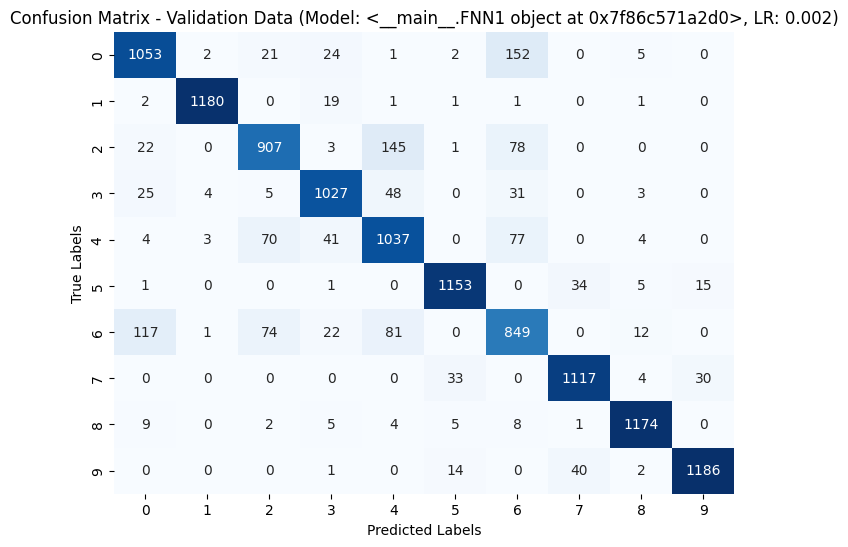

Epoch 1/10
Training Loss: 0.5604, Training Accuracy: 0.8001, Training Macro-F1 Score: 0.7986
Validation Loss: 0.4034, Validation Accuracy: 0.8564, Validation Macro-F1 Score: 0.8528
Epoch 2/10
Training Loss: 0.4239, Training Accuracy: 0.8464, Training Macro-F1 Score: 0.8457
Validation Loss: 0.3887, Validation Accuracy: 0.8591, Validation Macro-F1 Score: 0.8555
Epoch 3/10
Training Loss: 0.3878, Training Accuracy: 0.8589, Training Macro-F1 Score: 0.8583
Validation Loss: 0.3633, Validation Accuracy: 0.8699, Validation Macro-F1 Score: 0.8677
Epoch 4/10
Training Loss: 0.3568, Training Accuracy: 0.8693, Training Macro-F1 Score: 0.8689
Validation Loss: 0.3524, Validation Accuracy: 0.8761, Validation Macro-F1 Score: 0.8739
Epoch 5/10
Training Loss: 0.3383, Training Accuracy: 0.8760, Training Macro-F1 Score: 0.8756
Validation Loss: 0.3465, Validation Accuracy: 0.8754, Validation Macro-F1 Score: 0.8732
Epoch 6/10
Training Loss: 0.3211, Training Accuracy: 0.8808, Training Macro-F1 Score: 0.8806
Va

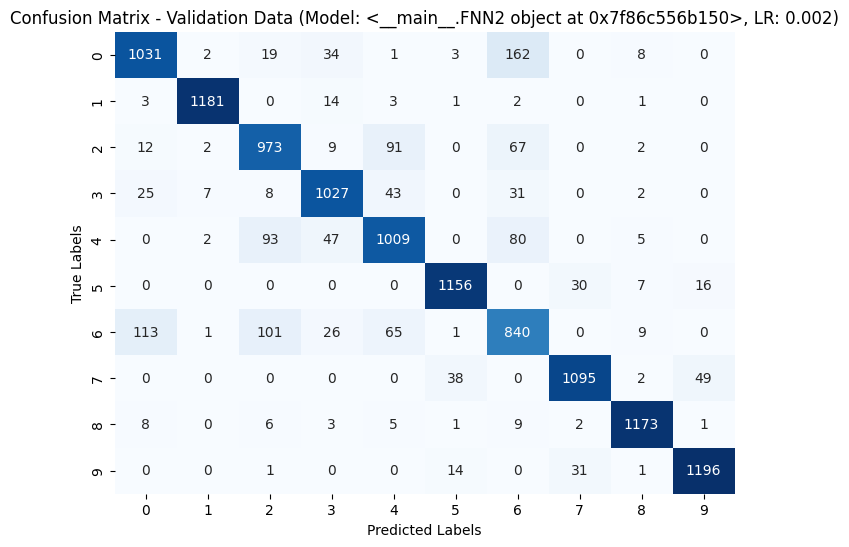

Epoch 1/10
Training Loss: 0.5771, Training Accuracy: 0.7960, Training Macro-F1 Score: 0.7939
Validation Loss: 0.4174, Validation Accuracy: 0.8492, Validation Macro-F1 Score: 0.8454
Epoch 2/10
Training Loss: 0.4350, Training Accuracy: 0.8410, Training Macro-F1 Score: 0.8402
Validation Loss: 0.3841, Validation Accuracy: 0.8627, Validation Macro-F1 Score: 0.8594
Epoch 3/10
Training Loss: 0.3985, Training Accuracy: 0.8529, Training Macro-F1 Score: 0.8524
Validation Loss: 0.3705, Validation Accuracy: 0.8680, Validation Macro-F1 Score: 0.8643
Epoch 4/10
Training Loss: 0.3703, Training Accuracy: 0.8643, Training Macro-F1 Score: 0.8639
Validation Loss: 0.3602, Validation Accuracy: 0.8747, Validation Macro-F1 Score: 0.8721
Epoch 5/10
Training Loss: 0.3487, Training Accuracy: 0.8708, Training Macro-F1 Score: 0.8706
Validation Loss: 0.3502, Validation Accuracy: 0.8743, Validation Macro-F1 Score: 0.8726
Epoch 6/10
Training Loss: 0.3332, Training Accuracy: 0.8754, Training Macro-F1 Score: 0.8752
Va

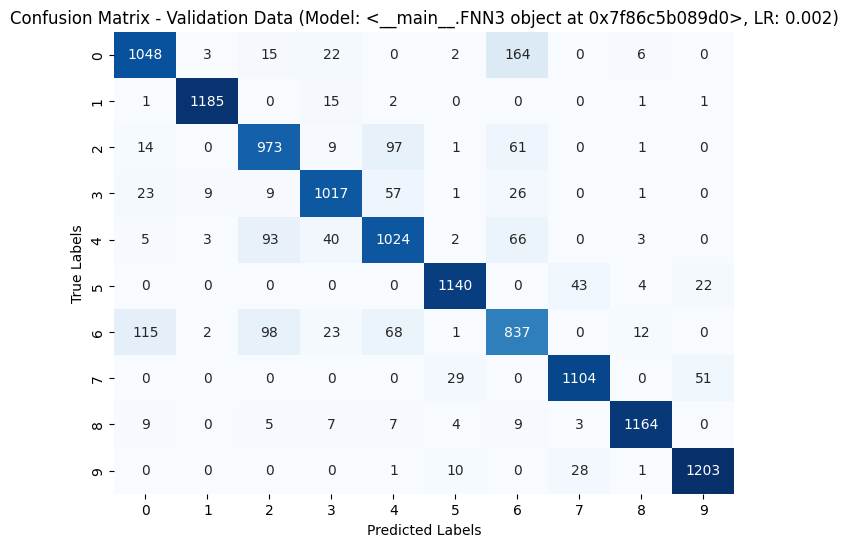

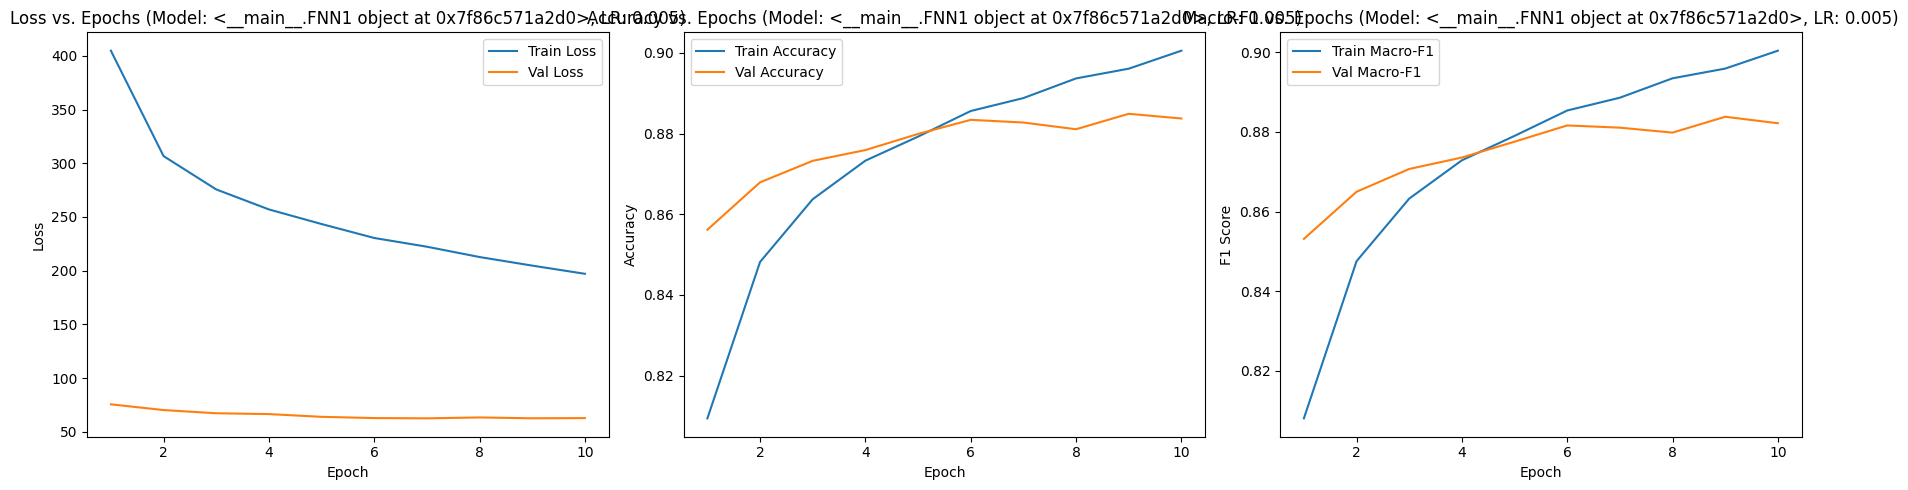

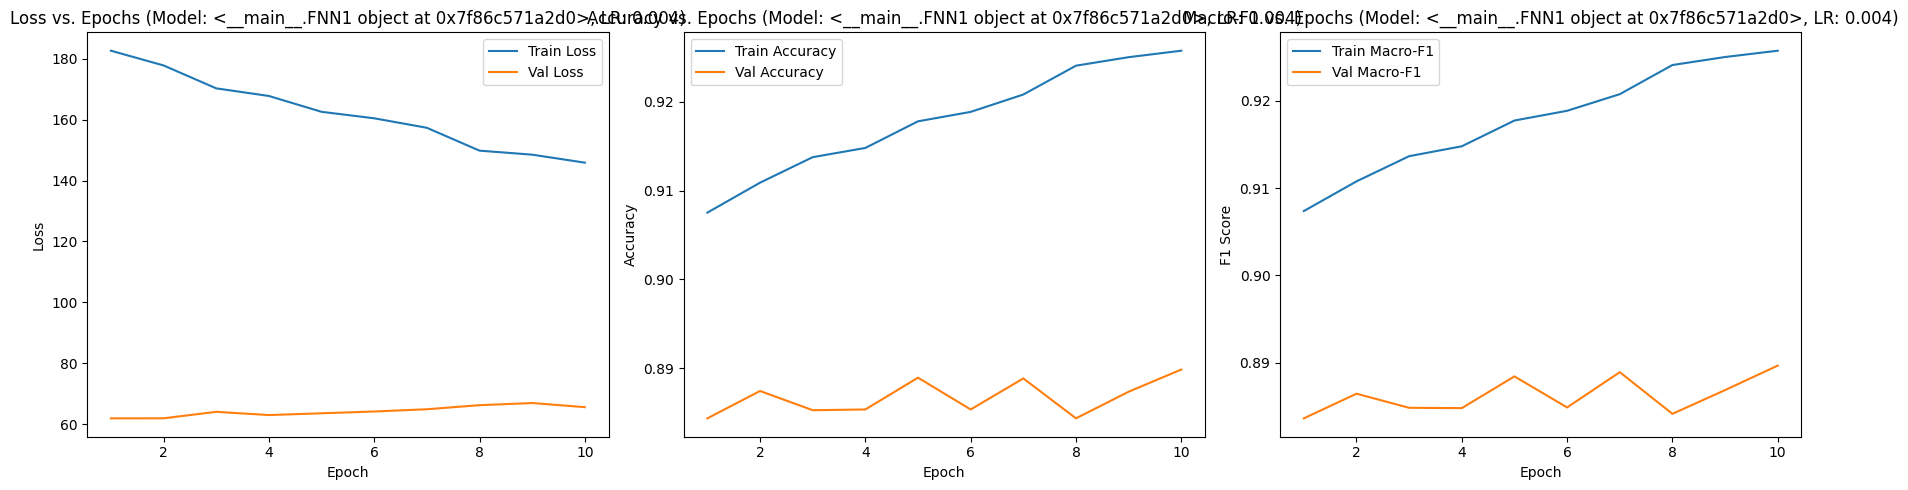

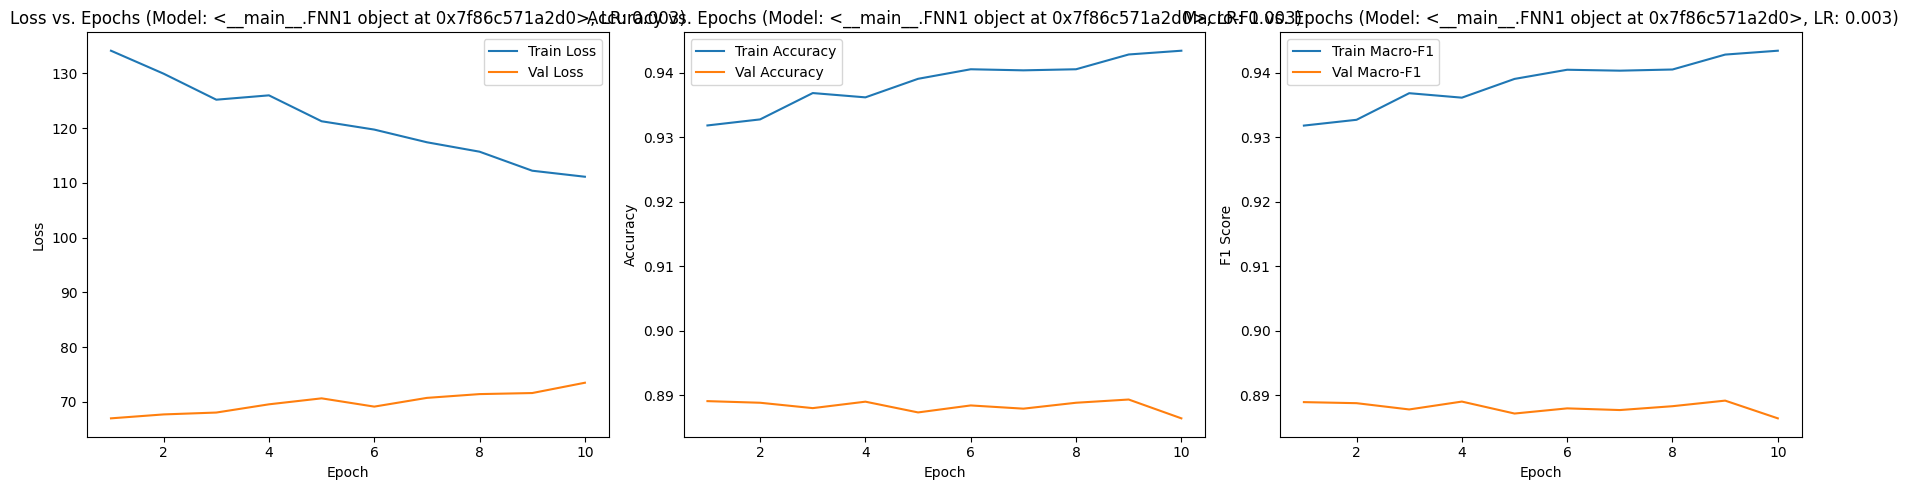

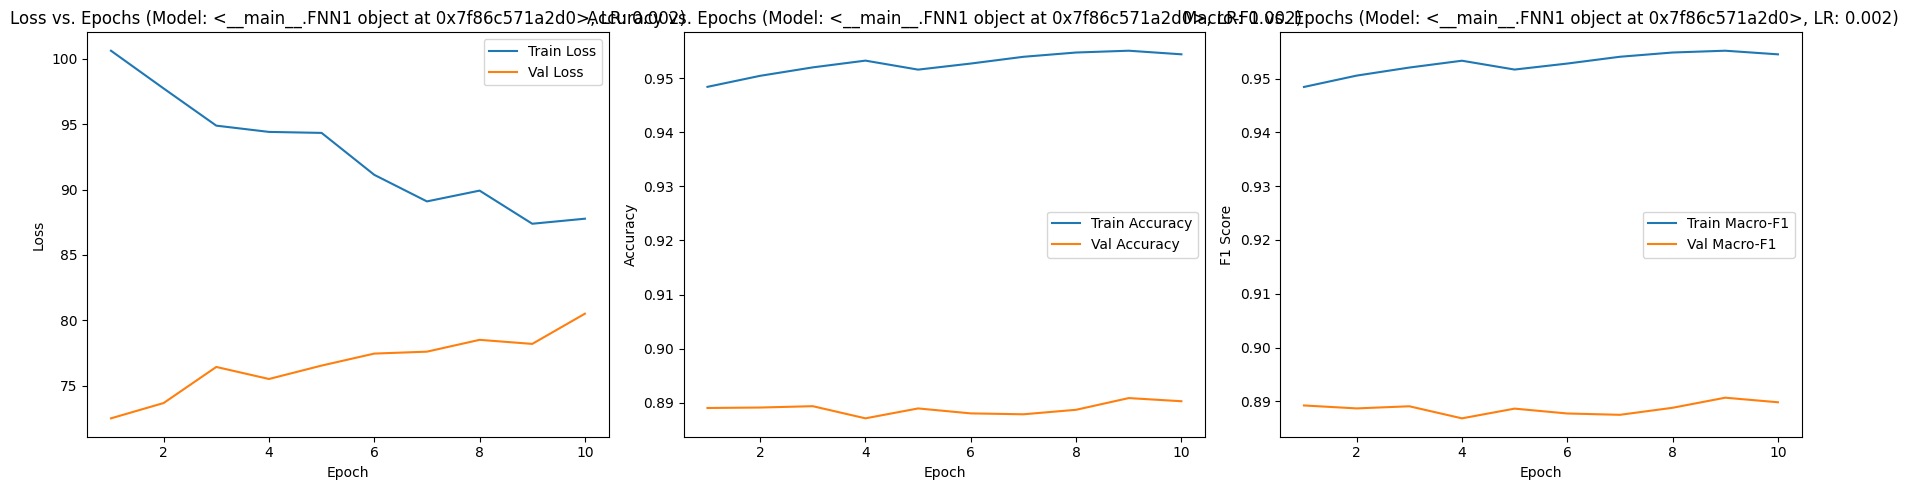

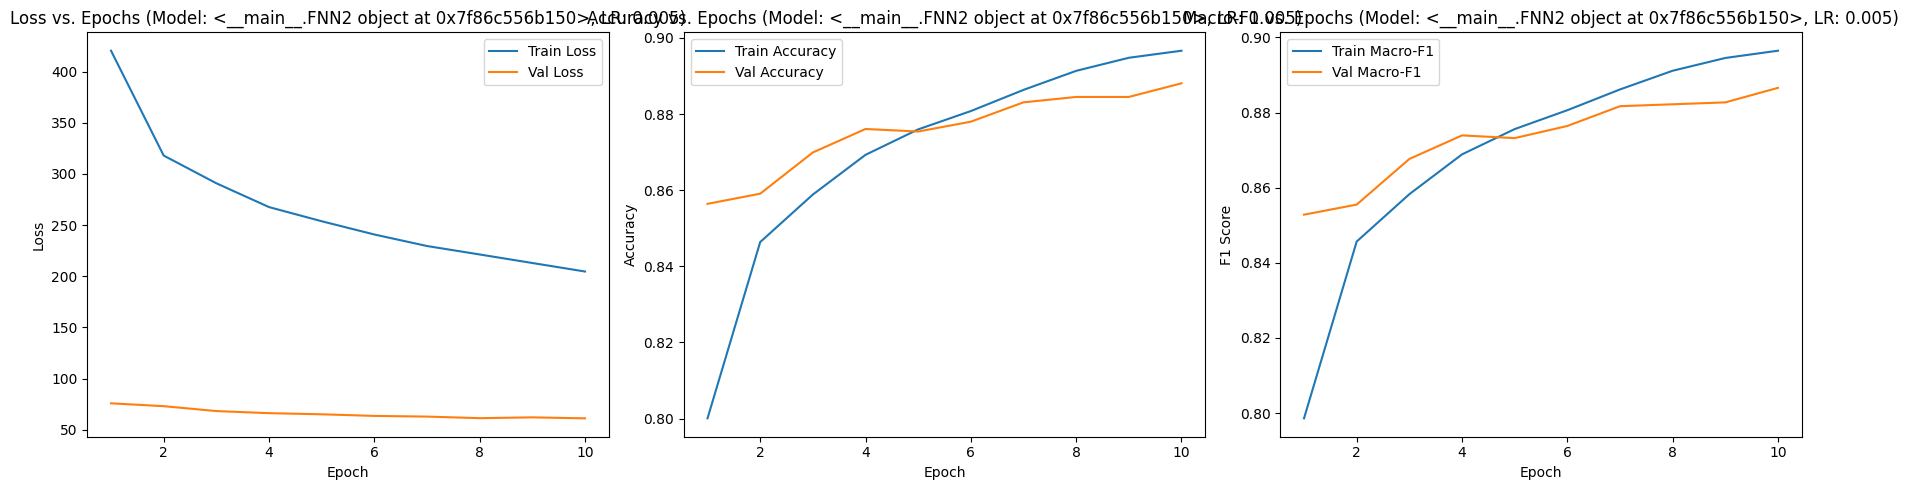

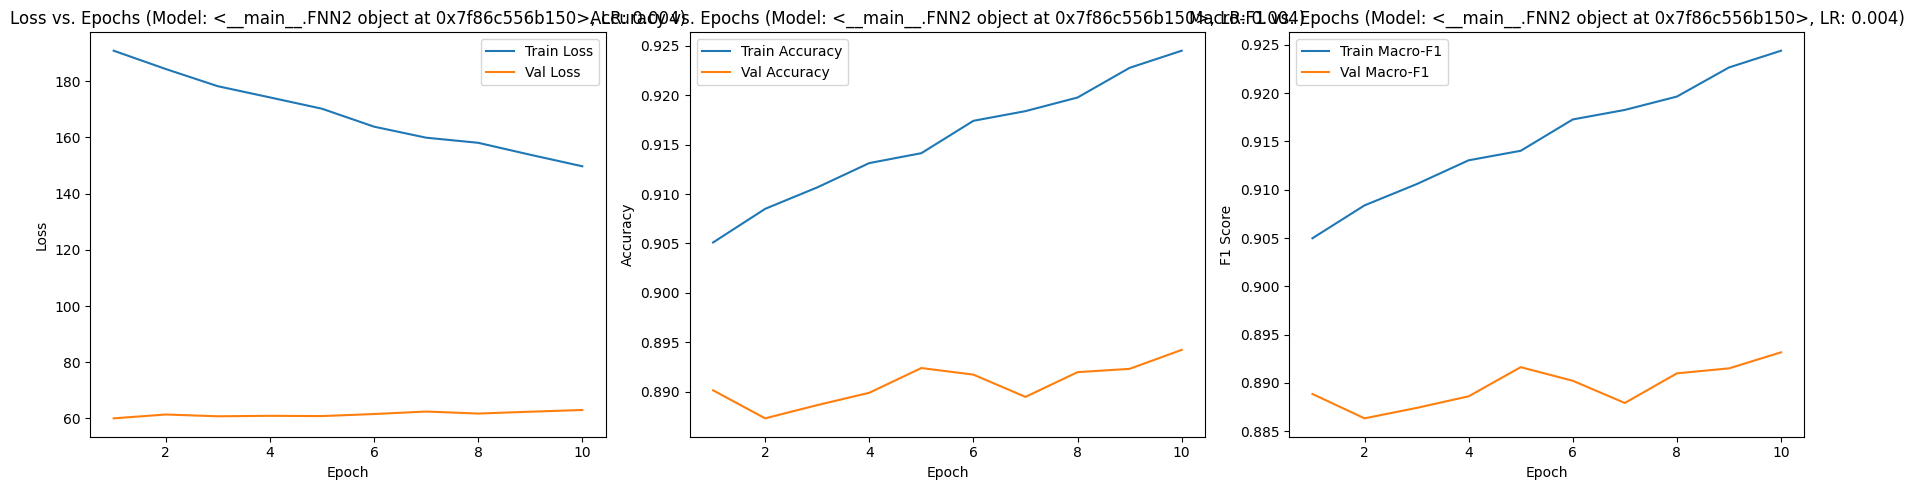

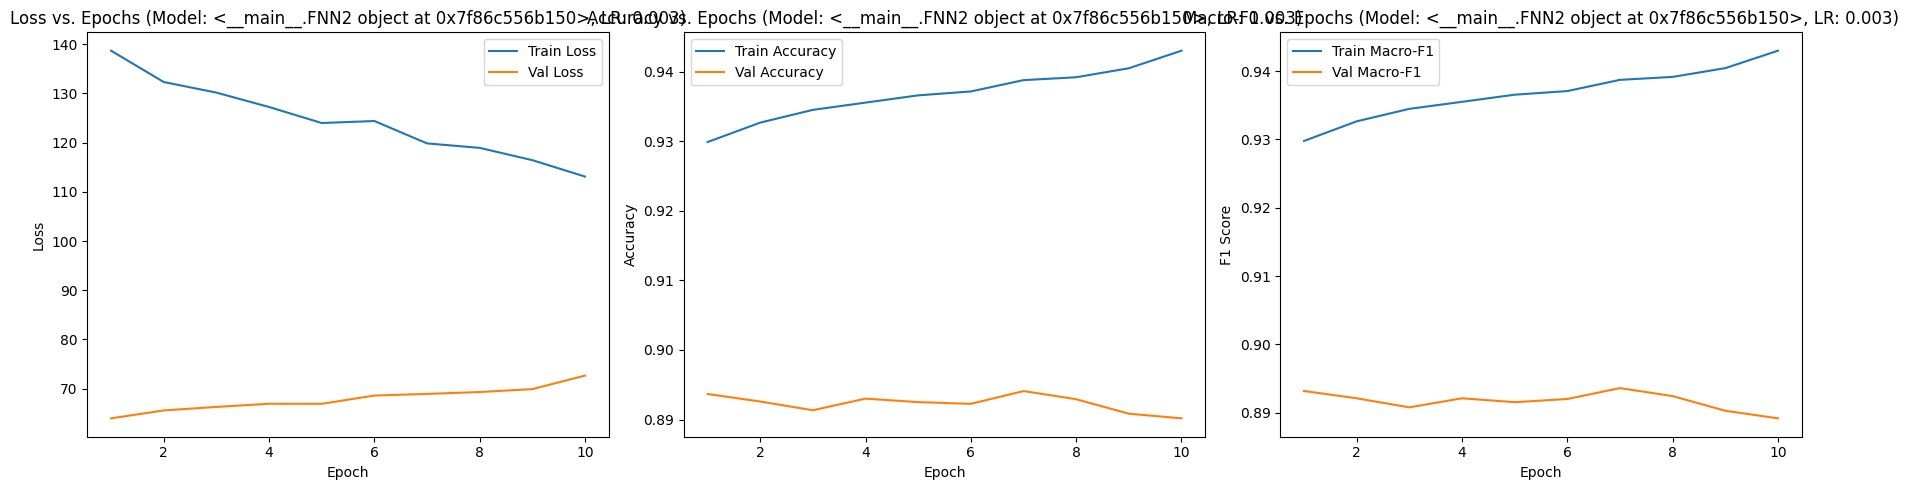

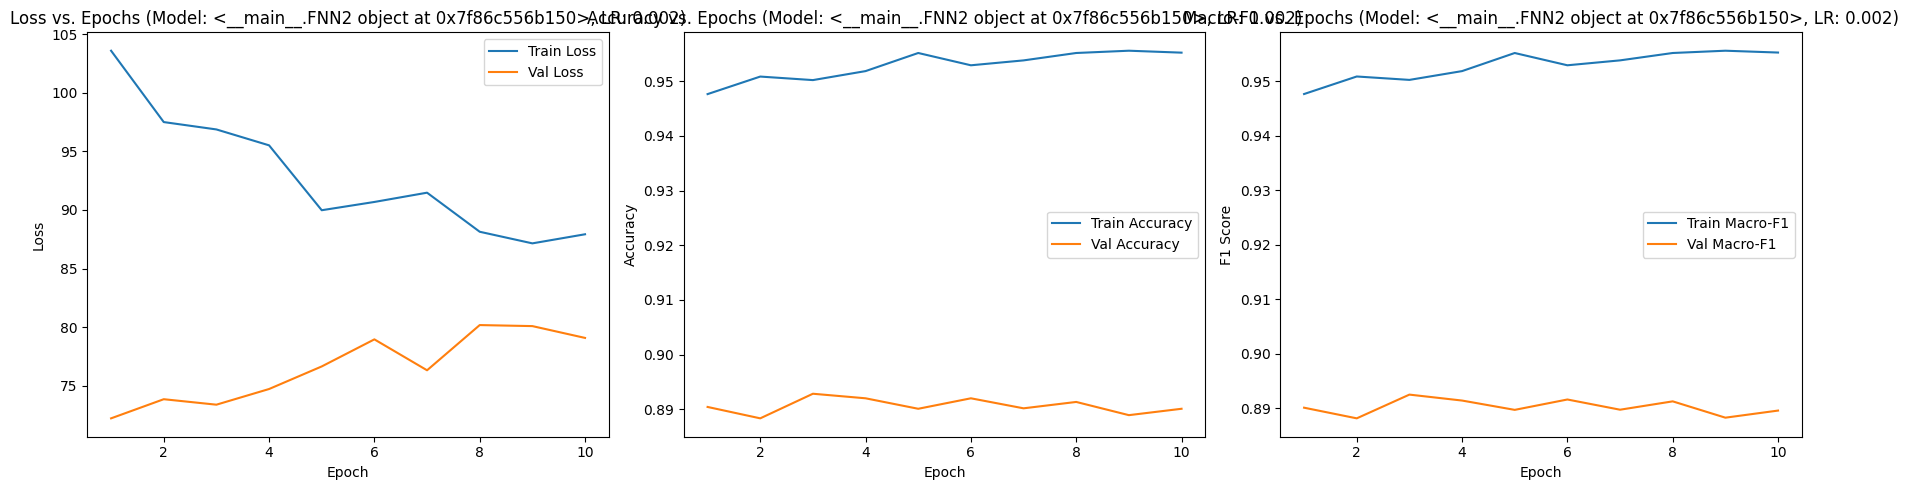

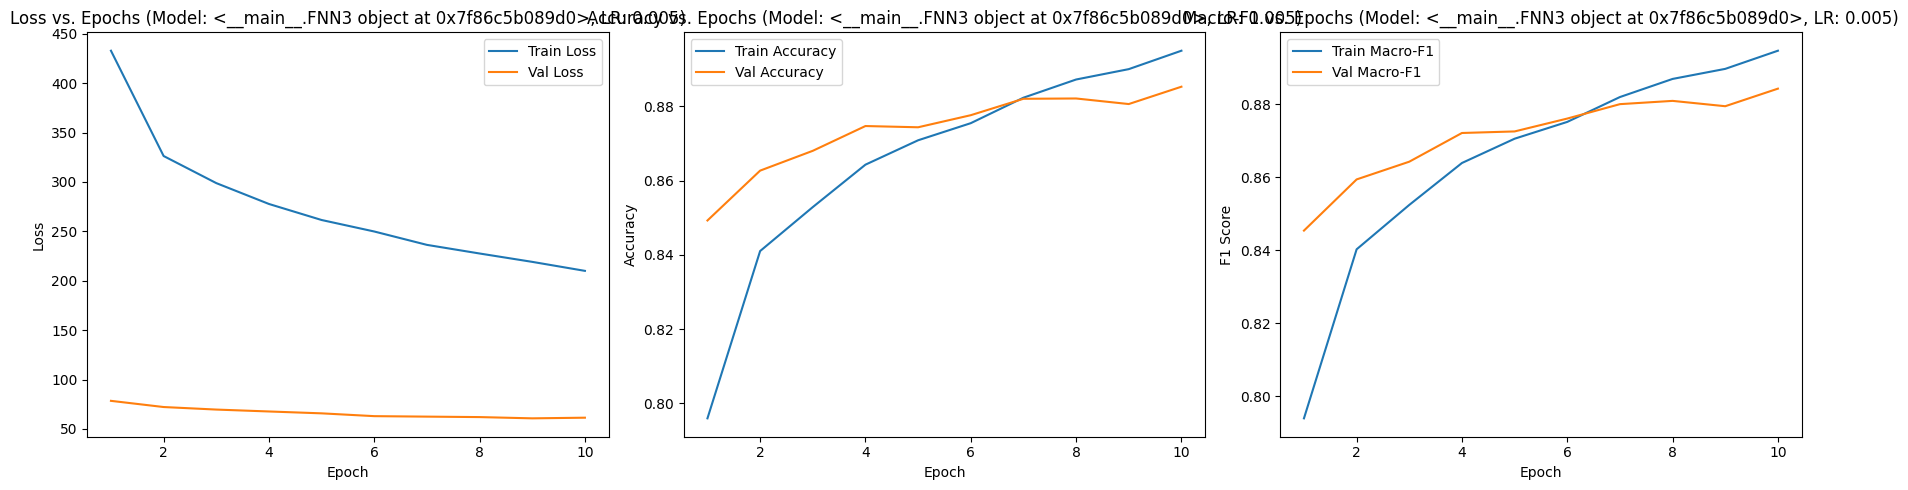

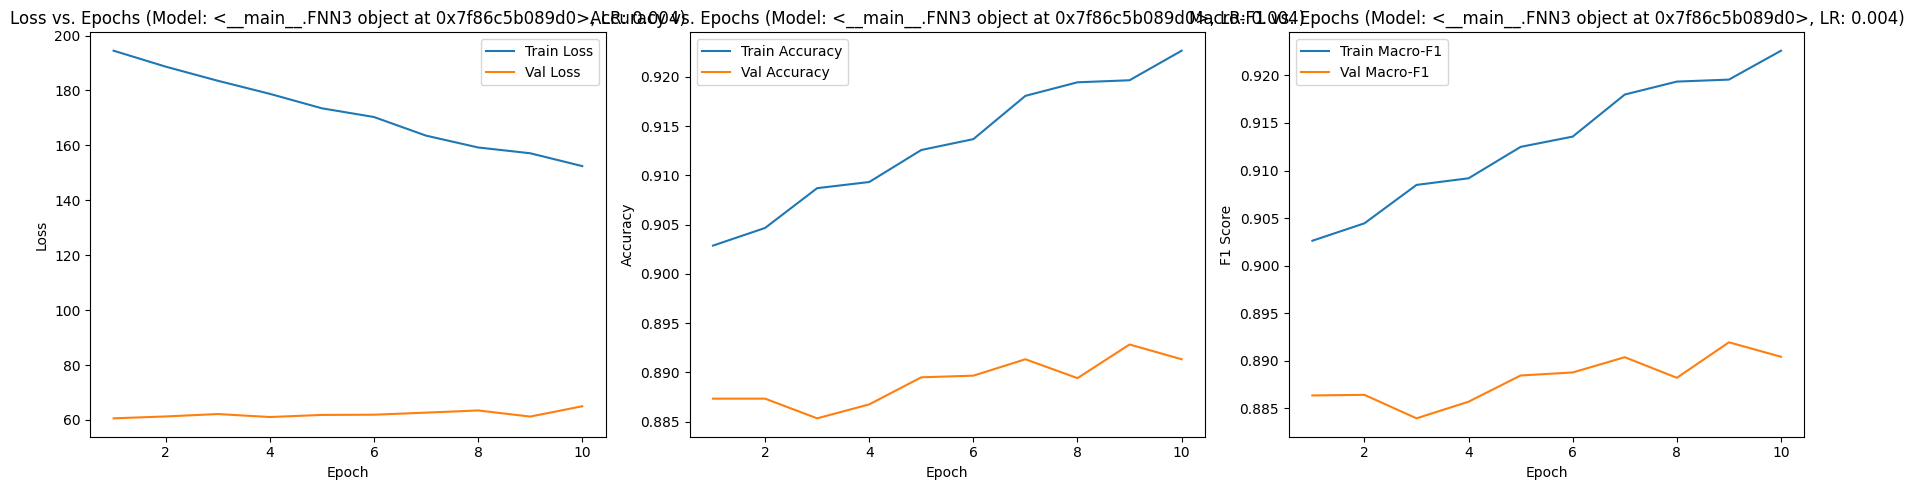

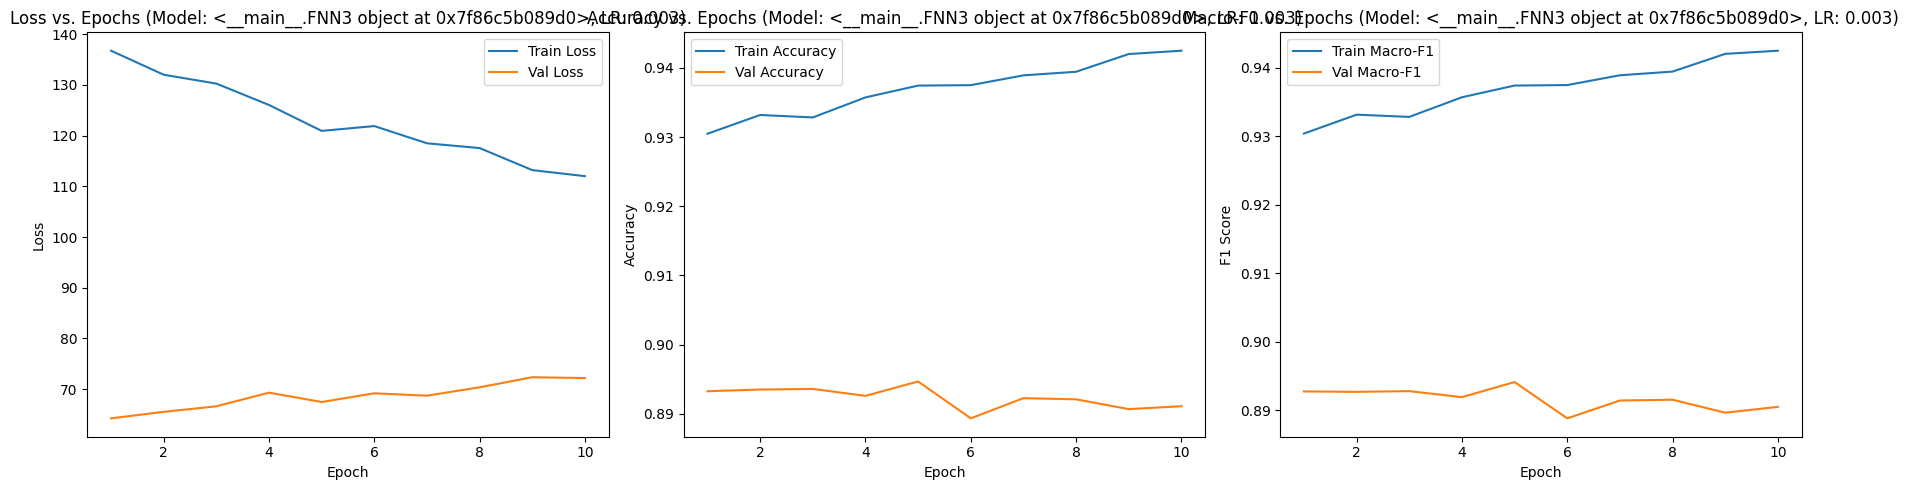

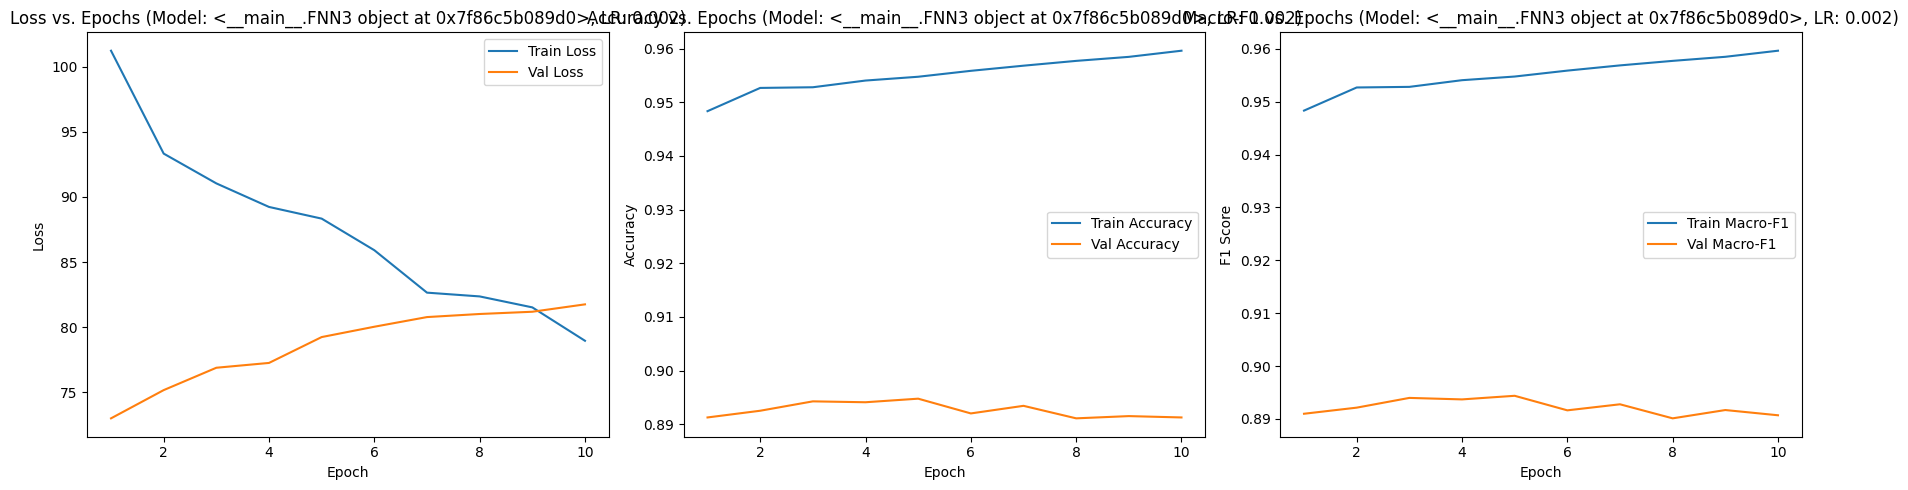

In [68]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

epochs = 10

models = [FNN1(), FNN2(), FNN3()]
alphas = [0.005, 0.004, 0.003, 0.002]

results = []

for model in models:
    for learning_rate in alphas:
        loss_fn = criterion
        train_losses = []
        train_accs = []
        train_f1s = []
        val_losses = []
        val_accs = []
        val_f1s = []
        for epoch in range(epochs):
        
            # Training loop
            model.train()
            train_epoch_loss = 0
            all_preds_train = []
            all_labels_train = []

            for X_batch, y_batch in train_loader:
                X_batch = X_batch.view(X_batch.size(0), -1).numpy() 
                y_batch_one_hot = np.eye(10)[y_batch.numpy()]  # One-hot encoding of labels

                preds = model.forward(X_batch)
                loss = loss_fn(preds, y_batch_one_hot)
                train_epoch_loss += loss

                grad_output = preds - y_batch_one_hot  
                model.backward(grad_output, learning_rate)
                
                predictions = np.argmax(preds, axis=1)
                all_preds_train.append(predictions)
                all_labels_train.append(y_batch.numpy())
            
            all_preds_train = np.concatenate(all_preds_train)
            all_labels_train = np.concatenate(all_labels_train)

            avg_train_loss = train_epoch_loss / len(train_loader)
            train_acc = accuracy_score(all_labels_train, all_preds_train)
            train_f1 = f1_score(all_labels_train, all_preds_train, average="macro")

            # Validation loop
            model.eval()
            val_epoch_loss = 0
            all_preds_val = []
            all_labels_val = []

            for X_batch, y_batch in val_loader:
                X_batch = X_batch.view(X_batch.size(0), -1).numpy()  
                y_batch_one_hot = np.eye(10)[y_batch.numpy()]  # One-hot encoding of labels

                preds = model.forward(X_batch)
                loss = loss_fn(preds, y_batch_one_hot)
                val_epoch_loss += loss

                predictions = np.argmax(preds, axis=1)
                all_preds_val.append(predictions)
                all_labels_val.append(y_batch.numpy())

            all_preds_val = np.concatenate(all_preds_val)
            all_labels_val = np.concatenate(all_labels_val)

            avg_val_loss = val_epoch_loss / len(val_loader)
            val_acc = accuracy_score(all_labels_val, all_preds_val) 
            val_f1 = f1_score(all_labels_val, all_preds_val, average="macro")

            # Print metrics for the current epoch
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Training Macro-F1 Score: {train_f1:.4f}")
            print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Validation Macro-F1 Score: {val_f1:.4f}")
            
            val_losses.append(val_epoch_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)
            train_losses.append(train_epoch_loss)
            train_accs.append(train_acc)
            train_f1s.append(train_f1)

        results.append({
            "model": model,
            "learning_rate": learning_rate,
            "train_losses": train_losses,
            "train_accs": train_accs,
            "train_f1s": train_f1s,
            "val_losses": val_losses,
            "val_accs": val_accs,
            "val_f1s": val_f1s
        })

    val_conf_matrix = confusion_matrix(all_labels_val, all_preds_val)
    plt.figure(figsize=(8, 6))
    sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - Validation Data (Model: {model}, LR: {learning_rate})")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Plot the metrics for each model and learning rate
for result in results:
    model = result["model"]
    lr = result["learning_rate"]

    plt.figure(figsize=(18, 5))

    # Plot Training and Validation Loss
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), result["train_losses"], label="Train Loss")
    plt.plot(range(1, epochs + 1), result["val_losses"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss vs. Epochs (Model: {model}, LR: {lr})")
    plt.legend()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), result["train_accs"], label="Train Accuracy")
    plt.plot(range(1, epochs + 1), result["val_accs"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy vs. Epochs (Model: {model}, LR: {lr})")
    plt.legend()

    # Plot Training and Validation F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), result["train_f1s"], label="Train Macro-F1")
    plt.plot(range(1, epochs + 1), result["val_f1s"], label="Val Macro-F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title(f"Macro-F1 vs. Epochs (Model: {model}, LR: {lr})")
    plt.legend()

    plt.tight_layout()
    plt.show()